In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, '../crispr_shrinkage/crispr_shrinkage/framework/')
import CrisprShrinkage as crispr_shrinkage
import CrisprShrinkageVisualization as crispr_shrinkage_visalization

In [2]:
from scipy.stats import binom
from scipy.stats import uniform
from scipy.stats import expon
import numpy as np 

null_proportion = 0.3
positive_proportion = 0.5
target_null_proportion = 0.3
target_positive_population = 0.7

num_ctrl_guides = 200
num_pos_guides = 50

reps = 3
max_dup_factor = 30
max_guide_molecule_factor = 20


get_positive_proportion = lambda pos_prop: ((1-pos_prop)*target_null_proportion) + (pos_prop)*target_positive_population

pop1_dup_factor_list = np.asarray([np.round(uniform.rvs(1, max_dup_factor)) for _ in range(reps)])
pop2_dup_factor_list = np.asarray([np.round(uniform.rvs(1, max_dup_factor)) for _ in range(reps)])

#expon.rvs(loc=1, scale=1000, size=num_guides)
#uniform.rvs(2, 200, size=num_guides)
def get_counts(num_guides, proportion):
    pop1_list_reps = []
    pop2_list_reps = []

    for rep_i in range(reps):
        n_list = np.round(uniform.rvs(2, max_guide_molecule_factor, size=num_guides)).astype(int)
        pop1_list = binom.rvs(n_list, proportion, size=num_guides) 
        pop2_list = n_list - pop1_list

        pop1_list_reps.append(pop1_list * pop1_dup_factor_list[rep_i])
        pop2_list_reps.append(pop2_list * pop2_dup_factor_list[rep_i])
    
    return np.asarray(pop1_list_reps), np.asarray(pop2_list_reps)


In [1]:
!singularity

'singularity' is not recognized as an internal or external command,
operable program or batch file.


In [3]:

get_kernel_values = lambda position, b,xrange : np.asarray([crispr_shrinkage.StatisticalHelperMethods.gaussian_kernel(i, position, b) for i in range(position-xrange, position+xrange+1)])

normalize_kernel_values = lambda kernel_values: (kernel_values-kernel_values.min())/(kernel_values.max() - kernel_values.min())

kernel_values_50 = normalize_kernel_values(get_kernel_values(50, 5, 5))
kernel_values_100 = normalize_kernel_values(get_kernel_values(100, 3, 3))

kernel_values_150 = normalize_kernel_values(get_kernel_values(150, 10, 10))
kernel_values_200 = normalize_kernel_values(get_kernel_values(200, 15, 15))

In [11]:
tiling_length = 300


positive_regions = [(50,5,kernel_values_50), (100,3,kernel_values_100), (150,10,kernel_values_150), (200,15,kernel_values_200)]
observation_guides = []
for position in range(tiling_length):
    guide_proportion = target_null_proportion
    for positive_region in positive_regions:
        positive_region_range = np.asarray(range(positive_region[0]-positive_region[1], positive_region[0]+positive_region[1]+1))
        if position in positive_region_range:
            guide_positive_proportion = positive_region[2][np.where(positive_region_range==position)[0][0]]
            guide_proportion = get_positive_proportion(guide_positive_proportion)
    counts = get_counts(1, guide_proportion)

    pop1_raw_count_reps = counts[0].transpose()[0]
    pop2_raw_count_reps = counts[1].transpose()[0]
    guide = crispr_shrinkage.Guide(identifier="observation_{}".format(position), position=position, sample_population_raw_count_reps=pop1_raw_count_reps, control_population_raw_count_reps=pop2_raw_count_reps, is_explanatory=True)

    observation_guides.append(guide)

In [619]:
#tiling_length = 300

#positive_regions = [100, 200, 300]
#observation_guides = []
#for position in range(tiling_length):
#    counts = get_counts(1, target_null_proportion)#

#    pop1_raw_count_reps = counts[0].transpose()[0]
#    pop2_raw_count_reps = counts[1].transpose()[0]
#    guide = crispr_shrinkage.Guide(identifier="observation_{}".format(position), position=position, pop1_raw_count_reps= pop1_raw_count_reps, pop2_raw_count_reps=pop2_raw_count_reps)

#    observation_guides.append(guide)

#observation_guides = np.asarray(observation_guides)

In [620]:
observation_guides[0].pop2_raw_count_reps/pop2_dup_factor_list

array([4., 5., 8.])

In [13]:
negative_guides = []
for i in range(num_ctrl_guides):
    counts = get_counts(1, null_proportion)
    pop1_raw_count_reps = counts[0].transpose()[0]
    pop2_raw_count_reps = counts[1].transpose()[0]
    guide = crispr_shrinkage.Guide(identifier="negative_{}".format(i), position=None, sample_population_raw_count_reps= pop1_raw_count_reps, control_population_raw_count_reps=pop2_raw_count_reps, is_explanatory=False)

    negative_guides.append(guide)

negative_guides = np.asarray(negative_guides)

In [14]:
positive_guides = []
for i in range(num_pos_guides):
    counts = get_counts(1, positive_proportion)
    pop1_raw_count_reps = counts[0].transpose()[0] + 1
    pop2_raw_count_reps = counts[1].transpose()[0] + 1
    guide = crispr_shrinkage.Guide(identifier="positive_{}".format(i), position=None, sample_population_raw_count_reps= pop1_raw_count_reps, control_population_raw_count_reps=pop2_raw_count_reps, is_explanatory=False)

    positive_guides.append(guide)

positive_guides = np.asarray(positive_guides)

In [623]:
positive_proportion

0.5

In [15]:
%%time
# LEFTOFF - just modifed result to return each guide set separately. So should be able to plot by position and verify that the shrinkage and all works well. Very interested to see if the negatiev controls are over shrunk. and positive controls. since they dont have position.
results1 = crispr_shrinkage.perform_adjustment(
    negative_control_guides = negative_guides,
    positive_control_guides = positive_guides,
    observation_guides = observation_guides,
    num_replicates = 3,
    include_observational_guides_in_fit = False,
    include_positive_control_guides_in_fit = False,
    sample_population_scaling_factors = pop1_dup_factor_list,
    control_population_scaling_factors = pop2_dup_factor_list,
    monte_carlo_trials = 1000,
    enable_neighborhood_prior =  True,
    neighborhood_bandwidth = 7,
    neighborhood_imputation_prior_strength = [0.00057222, 0.00158848, 0.00066747],
    neighborhood_imputation_likelihood_strength = [0.30339294, 0.22931624, 0.28337915],
    singleton_imputation_prior_strength = [0.00192637, 0.0018147, 0.00177171],
    deviation_weights = np.asarray([10,10,10]),
    KL_guide_set_weights = None,
    shrinkage_prior_strength = [0.725684, 0.76691641, 1.21555533], 
    posterior_estimator = "mean",
    random_seed = 234
    )


NEGATIVE_CONTROLS
Shrinkage Prior: a=[1.78574499 1.6586358  1.72387383], b=[3.51177251 3.6185118  3.4016832 ]
Shrinkage Prior: a=[1.78574499 1.6586358  1.72387383], b=[3.51177251 3.6185118  3.4016832 ]
Shrinkage Prior: a=[1.78574499 1.6586358  1.72387383], b=[3.51177251 3.6185118  3.4016832 ]
Shrinkage Prior: a=[1.78574499 1.6586358  1.72387383], b=[3.51177251 3.6185118  3.4016832 ]
Shrinkage Prior: a=[1.78574499 1.6586358  1.72387383], b=[3.51177251 3.6185118  3.4016832 ]
Shrinkage Prior: a=[1.78574499 1.6586358  1.72387383], b=[3.51177251 3.6185118  3.4016832 ]
Shrinkage Prior: a=[1.78574499 1.6586358  1.72387383], b=[3.51177251 3.6185118  3.4016832 ]
Shrinkage Prior: a=[1.78574499 1.6586358  1.72387383], b=[3.51177251 3.6185118  3.4016832 ]
Shrinkage Prior: a=[1.78574499 1.6586358  1.72387383], b=[3.51177251 3.6185118  3.4016832 ]
Shrinkage Prior: a=[1.78574499 1.6586358  1.72387383], b=[3.51177251 3.6185118  3.4016832 ]
Shrinkage Prior: a=[1.78574499 1.6586358  1.72387383], b=[3.51

In [2]:
crispr_shrinkage_visualization_input = crispr_shrinkage_visalization.prepare_crispr_shrinkage_visualization_input(results1)

NameError: name 'results1' is not defined

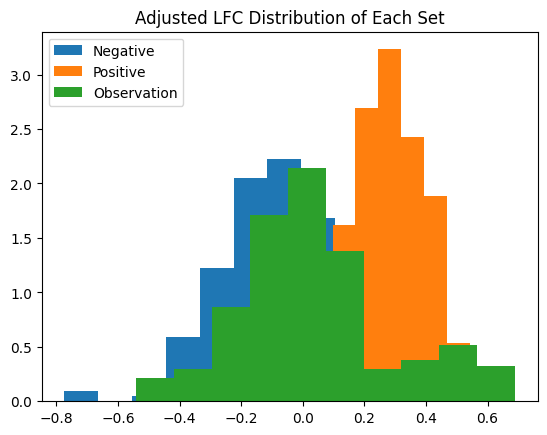

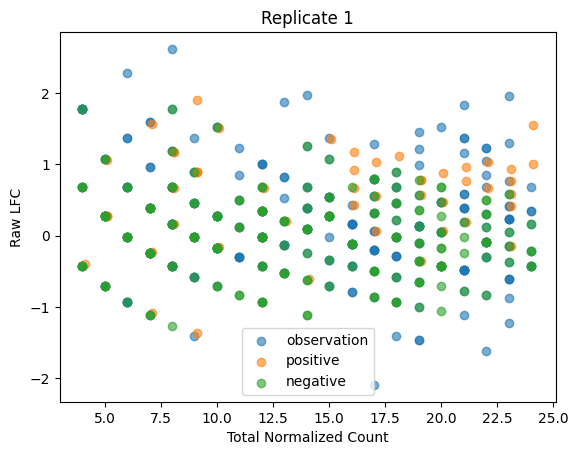

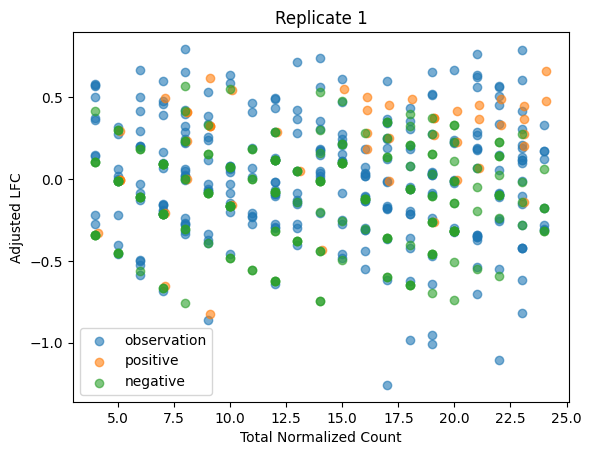

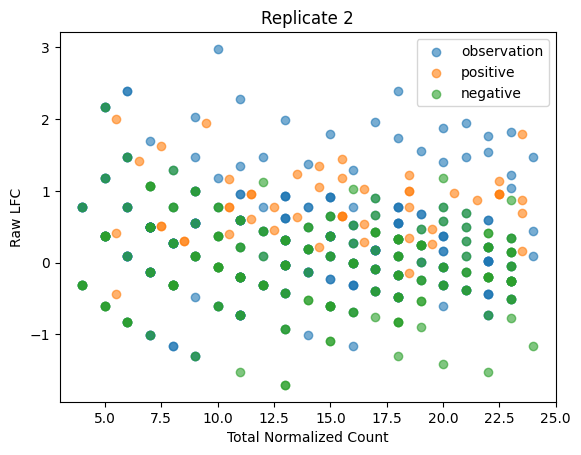

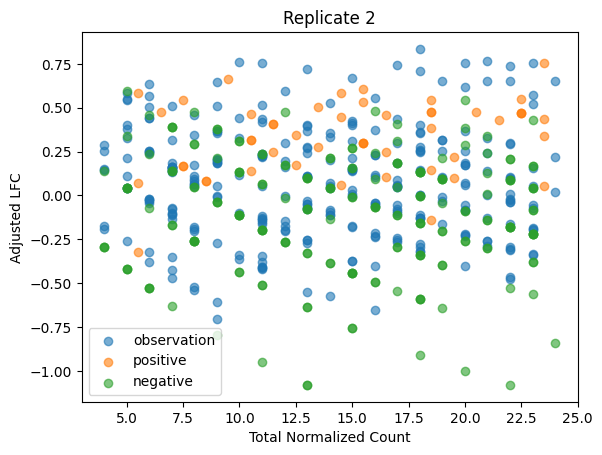

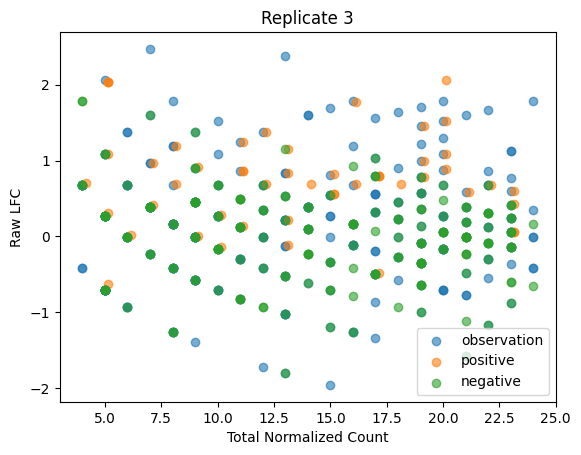

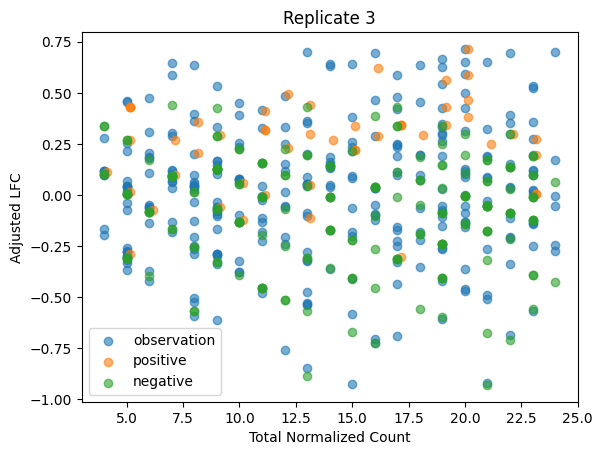

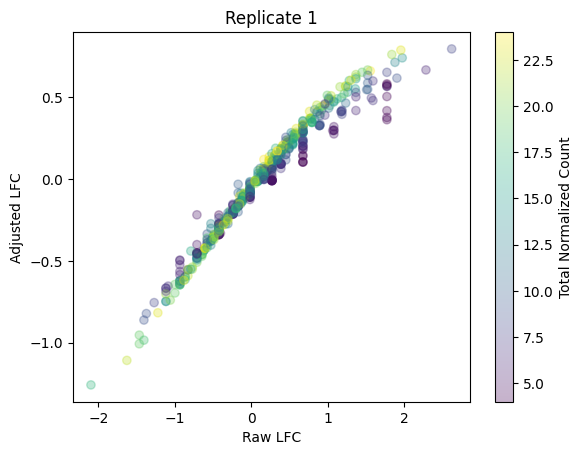

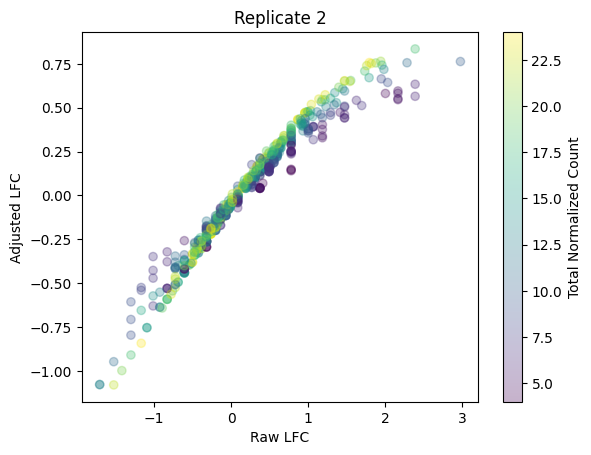

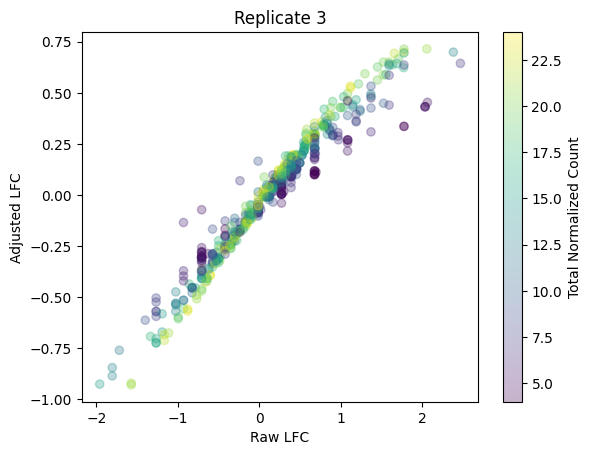

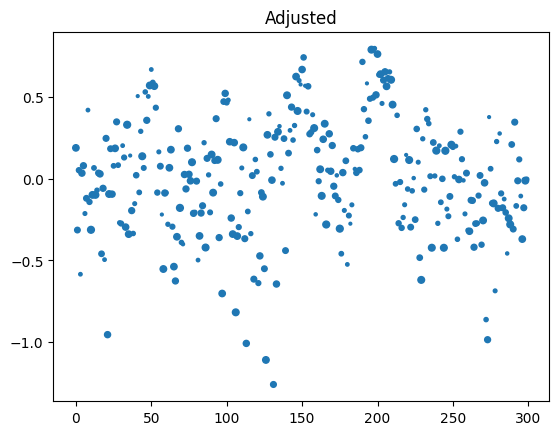

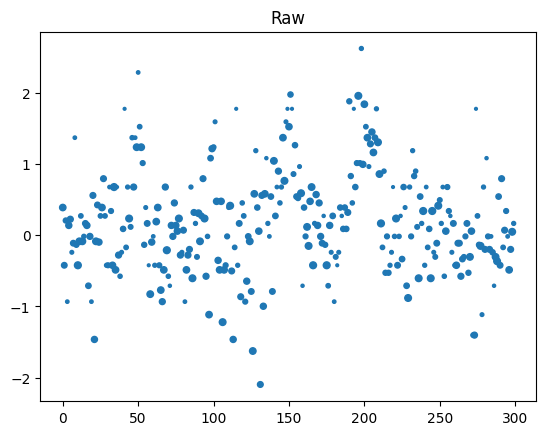

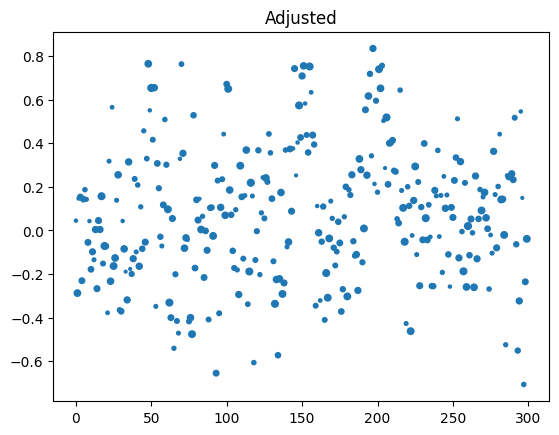

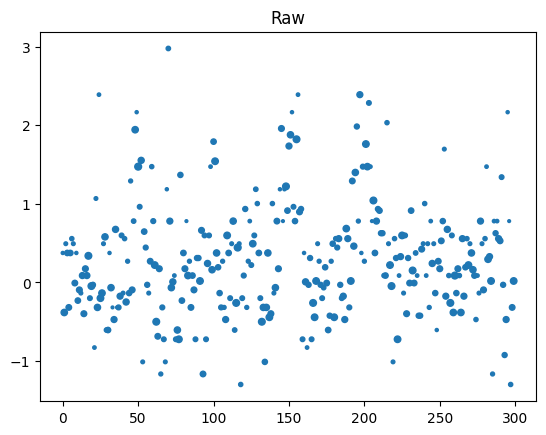

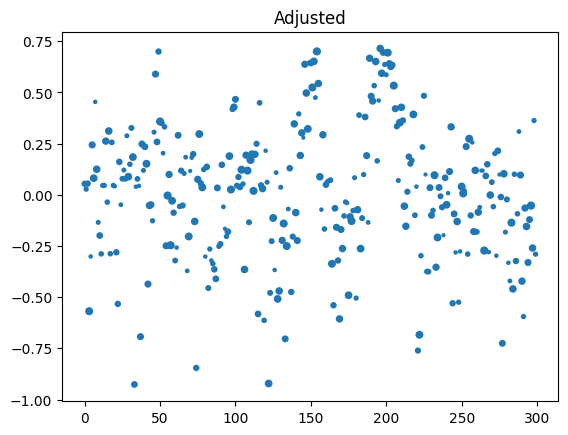

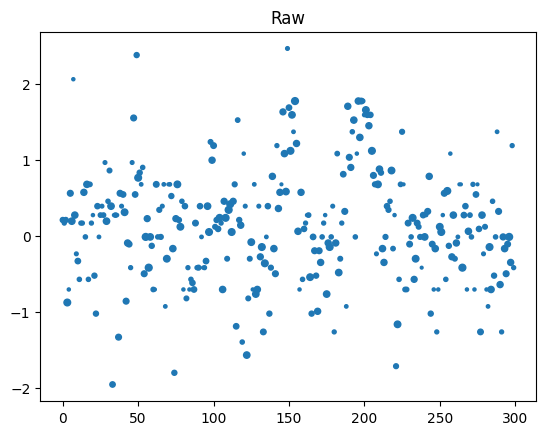

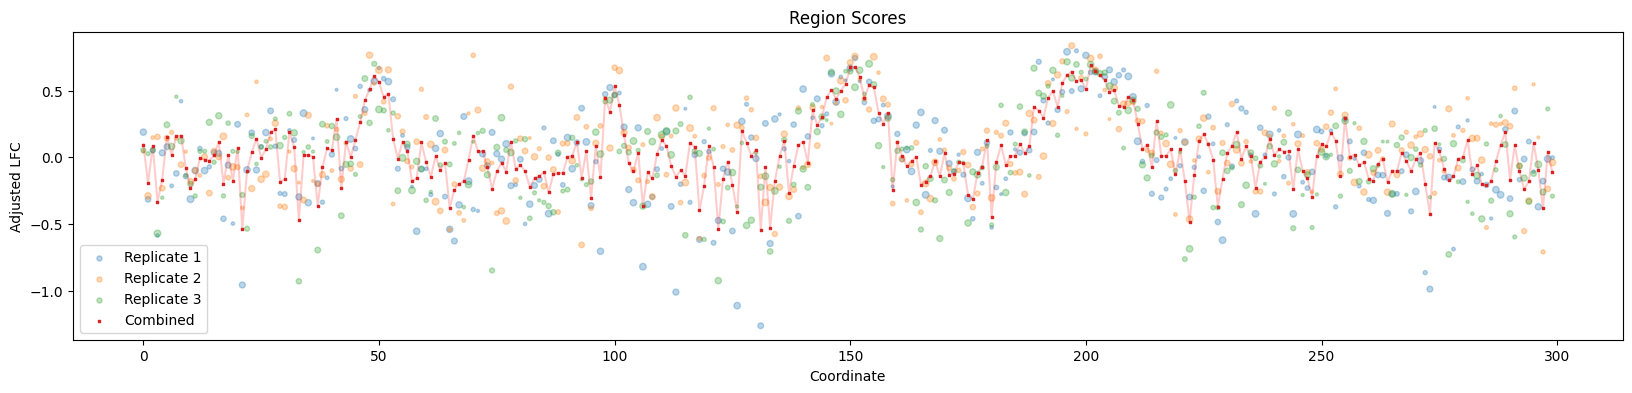

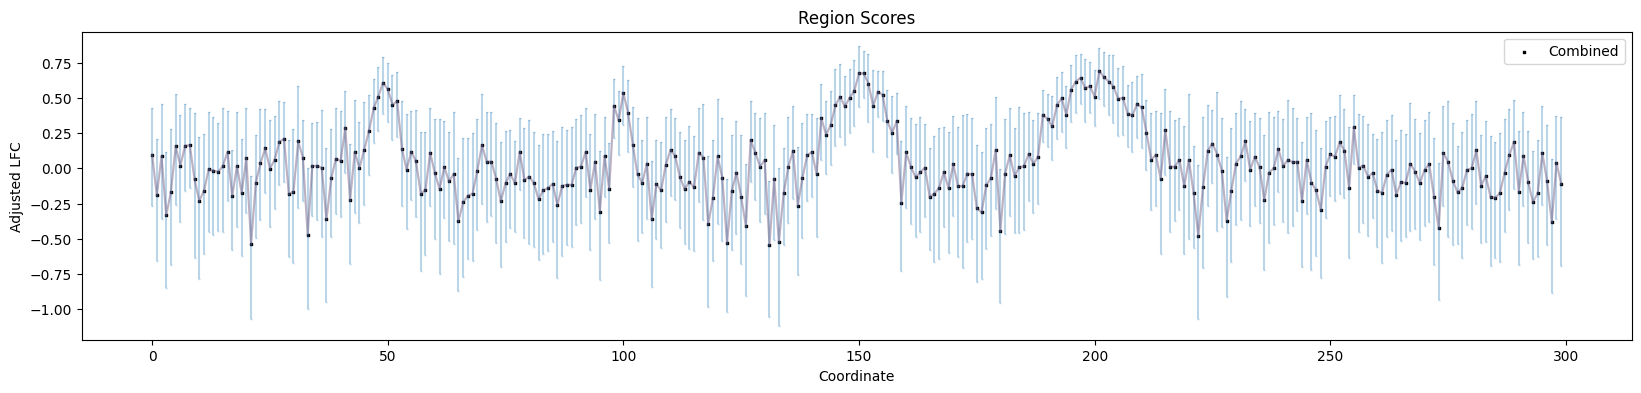

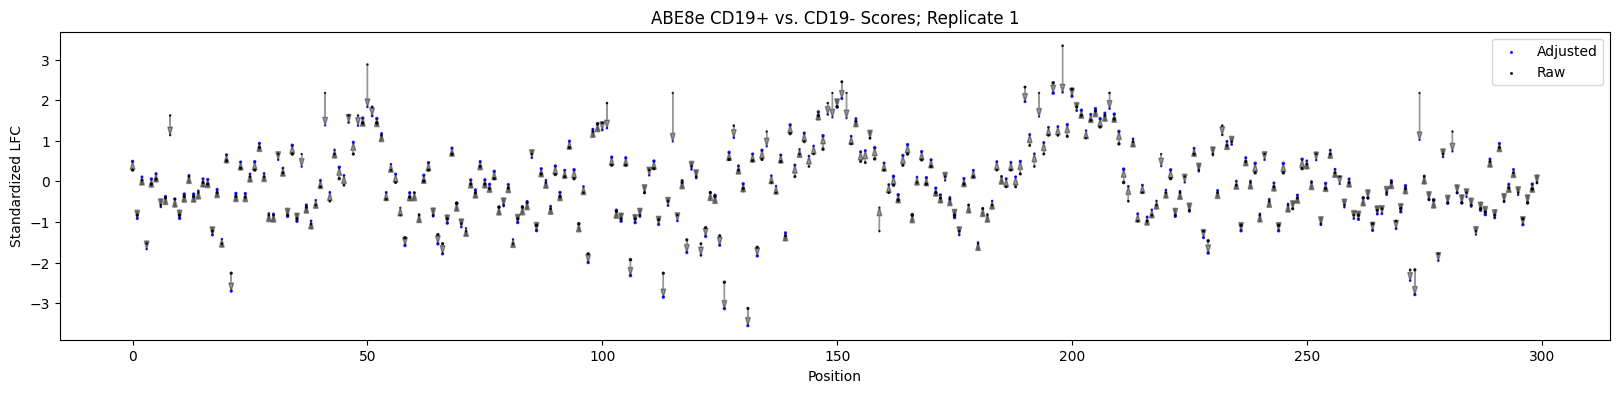

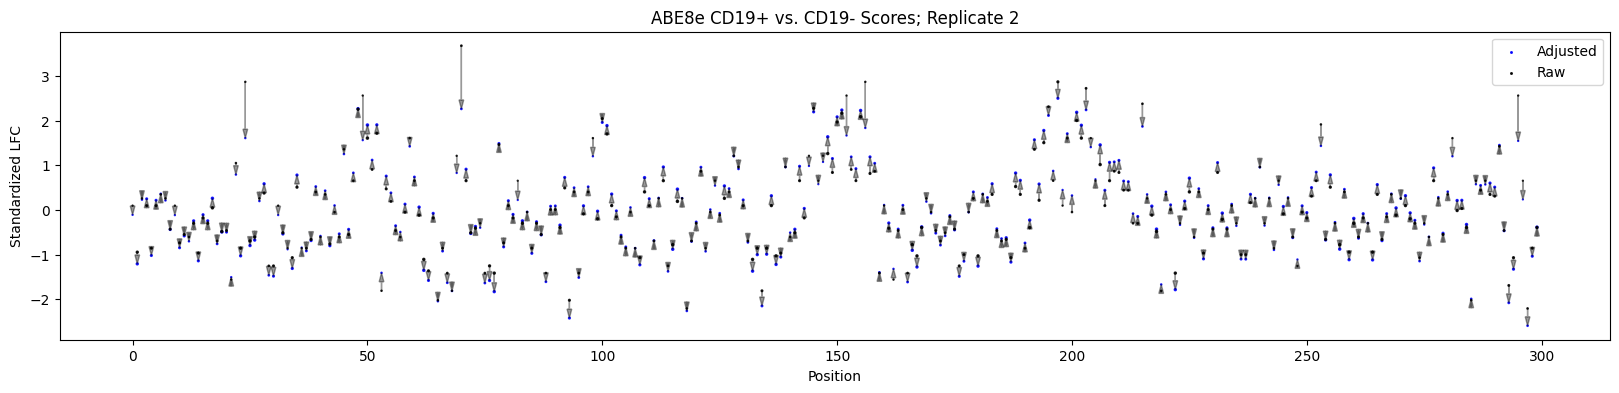

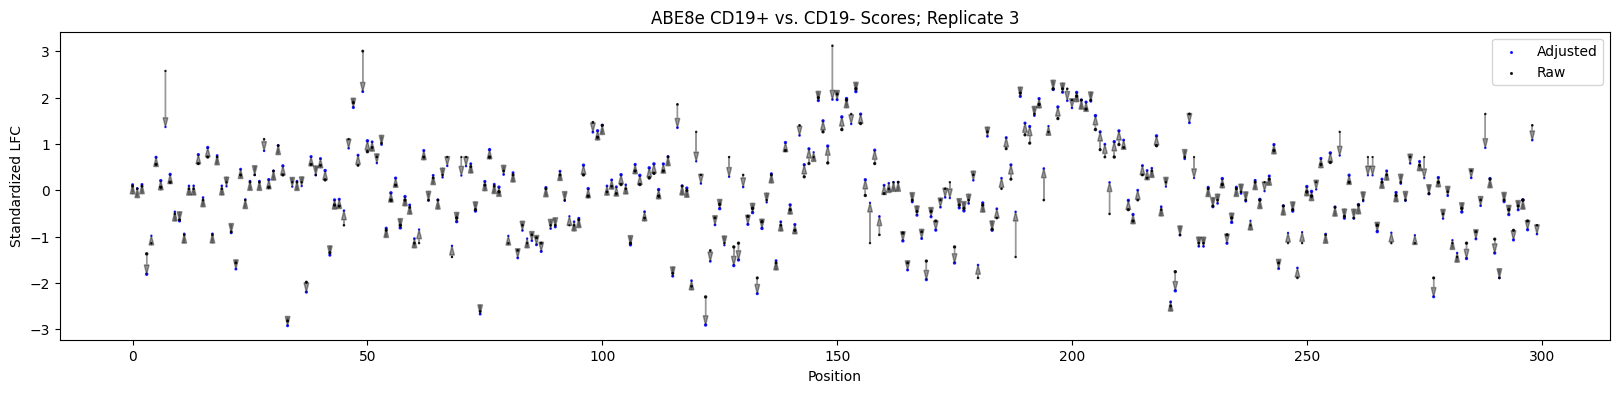

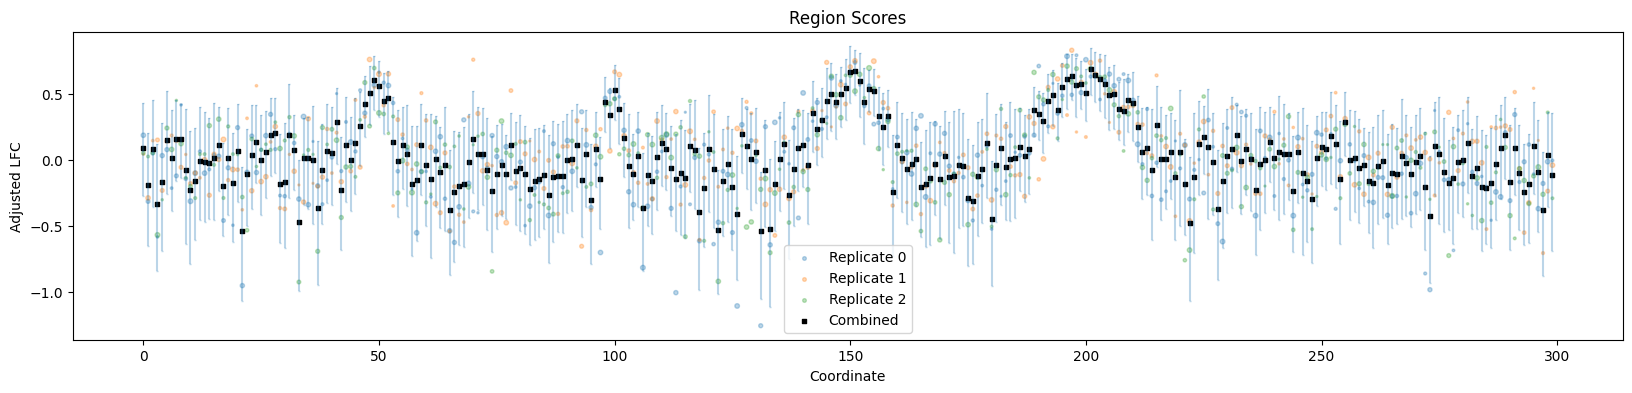

In [16]:
crispr_shrinkage_visalization.visualize_crispr_shrinkage_results(results1)

In [625]:
results = results1

In [626]:
positive_positions1 = [guide.position for guide in results1.adjusted_positive_control_guides]
observational_position1 = [guide.position for guide in results1.adjusted_observation_guides]

In [627]:
positive_positions = [guide.position for guide in results.adjusted_positive_control_guides]
observational_position = [guide.position for guide in results.adjusted_observation_guides]

In [628]:
negative_lfc = [guide.LFC_estimate_combined for guide in results.adjusted_negative_control_guides]
positive_lfc = [guide.LFC_estimate_combined for guide in results.adjusted_positive_control_guides]
observational_lfc = [guide.LFC_estimate_combined for guide in results.adjusted_observation_guides]

In [629]:
negative_lfc1 = [guide.LFC_estimate_combined for guide in results1.adjusted_negative_control_guides]
positive_lfc1 = [guide.LFC_estimate_combined for guide in results1.adjusted_positive_control_guides]
observational_lfc1 = [guide.LFC_estimate_combined for guide in results1.adjusted_observation_guides]

negative_lfc2 = [guide.LFC_estimate_combined for guide in results2.adjusted_negative_control_guides]
positive_lfc2 = [guide.LFC_estimate_combined for guide in results2.adjusted_positive_control_guides]
observational_lfc2 = [guide.LFC_estimate_combined for guide in results2.adjusted_observation_guides]

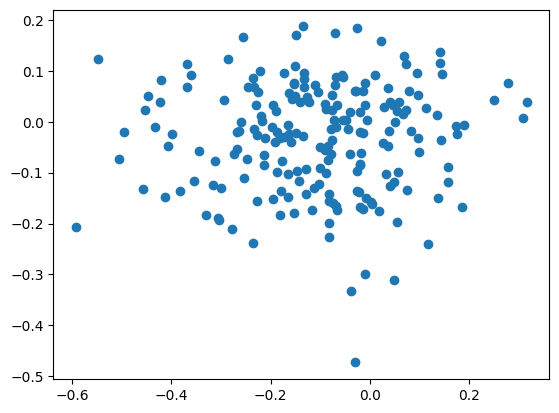

In [630]:
plt.scatter(negative_lfc, negative_lfc2)

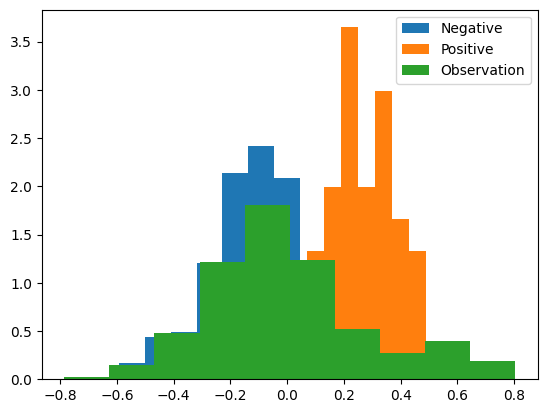

In [631]:
import matplotlib.pyplot as plt
plt.hist(negative_lfc, density=True, label="Negative")
plt.hist(positive_lfc, density=True, label="Positive")
plt.hist(observational_lfc, density=True, label="Observation")
plt.legend()

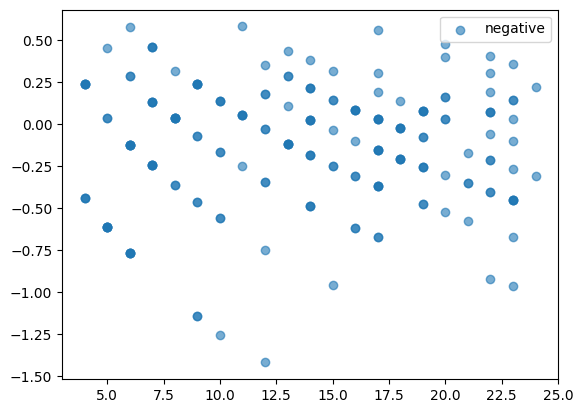

In [632]:
reps = range(3)
observational_lfc_rep = [[guide.LFC_estimate_per_replicate[rep_i] for guide in results.adjusted_observation_guides] for rep_i in reps]
observational_count_rep = [[guide.pop1_normalized_count_reps[rep_i] + guide.pop2_normalized_count_reps[rep_i] for guide in results.adjusted_observation_guides] for rep_i in reps]
positive_lfc_rep = [[guide.LFC_estimate_per_replicate[rep_i] for guide in results.adjusted_positive_control_guides]  for rep_i in reps]
positive_count_rep = [[guide.pop1_normalized_count_reps[rep_i] + guide.pop2_normalized_count_reps[rep_i] for guide in results.adjusted_positive_control_guides]  for rep_i in reps]

negative_lfc_rep = [[guide.LFC_estimate_per_replicate[rep_i] for guide in results.adjusted_negative_control_guides]  for rep_i in reps]

negative_count_rep = [[guide.pop1_normalized_count_reps[rep_i] + guide.pop1_normalized_count_reps[rep_i] for guide in results.adjusted_negative_control_guides] for rep_i in reps] # WRONG
negative_count_rep = [[guide.pop1_normalized_count_reps[rep_i] + guide.pop2_normalized_count_reps[rep_i] for guide in results.adjusted_negative_control_guides] for rep_i in reps] # RIGHT

#plt.scatter(observational_count_rep, observational_lfc_rep, alpha=0.6, label="observation")
#plt.scatter(positive_count_rep, positive_lfc_rep, alpha=0.6, label="positive")
plt.scatter(negative_count_rep[0], negative_lfc_rep[0], alpha=0.6, label="negative")
plt.legend()
plt.show()

In [633]:
pop1_negative_controls = np.asarray([guide.pop1_normalized_count_reps  for guide in results.adjusted_negative_control_guides]).sum(axis=0)

pop2_negative_controls = np.asarray([guide.pop2_normalized_count_reps  for guide in results.adjusted_negative_control_guides]).sum(axis=0)

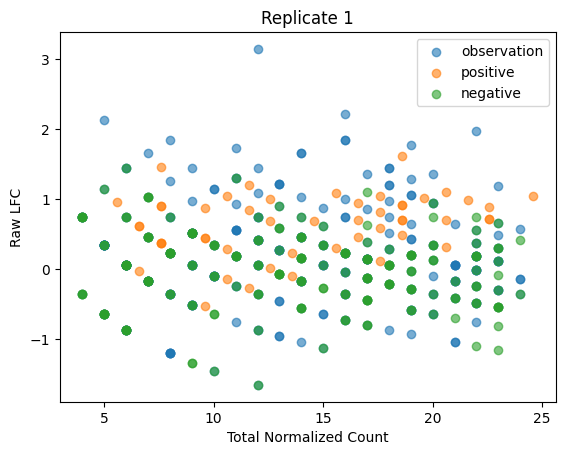

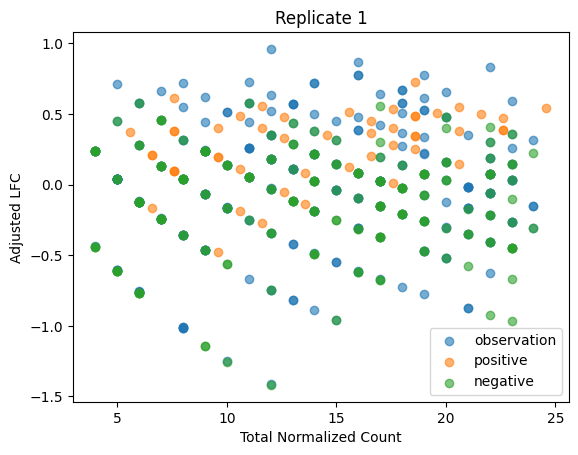

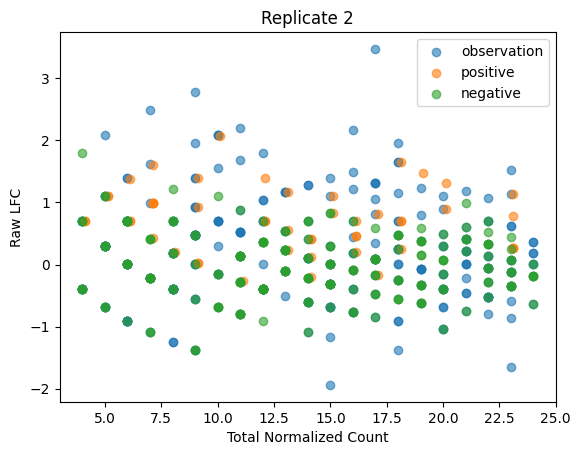

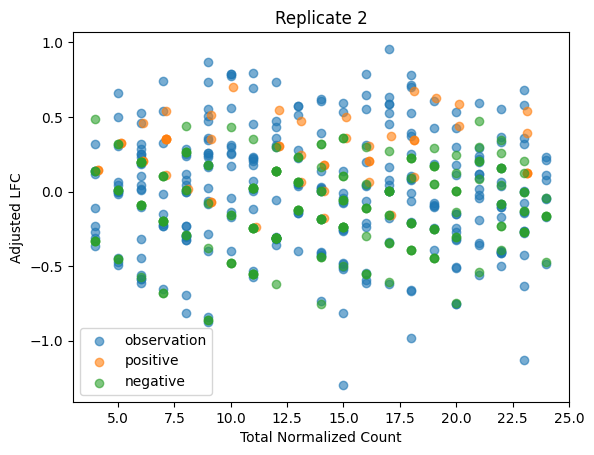

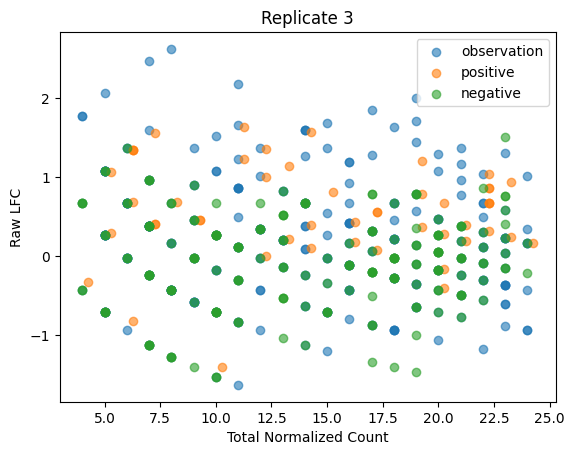

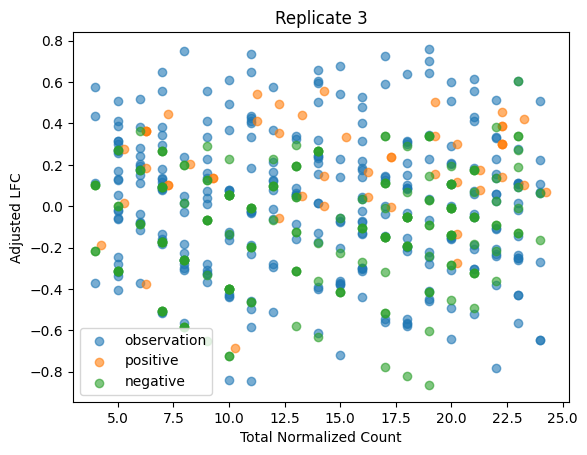

In [634]:
observational_raw_lfc_rep = [[np.log((guide.pop1_normalized_count_reps[rep_i] * pop2_negative_controls[rep_i])/(guide.pop2_normalized_count_reps[rep_i] * pop1_negative_controls[rep_i])) for guide in results.adjusted_observation_guides]  for rep_i in reps]

positive_raw_lfc_rep = [[np.log((guide.pop1_normalized_count_reps[rep_i] * pop2_negative_controls[rep_i])/(guide.pop2_normalized_count_reps[rep_i] * pop1_negative_controls[rep_i])) for guide in results.adjusted_positive_control_guides] for rep_i in reps]

negative_raw_lfc_rep = [[np.log((guide.pop1_normalized_count_reps[rep_i] * pop2_negative_controls[rep_i])/(guide.pop2_normalized_count_reps[rep_i] * pop1_negative_controls[rep_i])) for guide in results.adjusted_negative_control_guides]  for rep_i in reps]

for rep_i in range(3):
    plt.scatter(observational_count_rep[rep_i], observational_raw_lfc_rep[rep_i], alpha=0.6, label="observation")
    plt.scatter(positive_count_rep[rep_i], positive_raw_lfc_rep[rep_i], alpha=0.6, label="positive")
    plt.scatter(negative_count_rep[rep_i], negative_raw_lfc_rep[rep_i], alpha=0.6, label="negative")
    plt.xlabel("Total Normalized Count")
    plt.ylabel("Raw LFC")
    plt.title("Replicate {}".format(rep_i+1))
    plt.legend()
    plt.show()

    plt.scatter(observational_count_rep[rep_i], observational_lfc_rep[rep_i], alpha=0.6, label="observation")
    plt.scatter(positive_count_rep[rep_i], positive_lfc_rep[rep_i], alpha=0.6, label="positive")
    plt.scatter(negative_count_rep[rep_i], negative_lfc_rep[rep_i], alpha=0.6, label="negative")
    plt.xlabel("Total Normalized Count")
    plt.ylabel("Adjusted LFC")
    plt.title("Replicate {}".format(rep_i+1))
    plt.legend()
    plt.show()

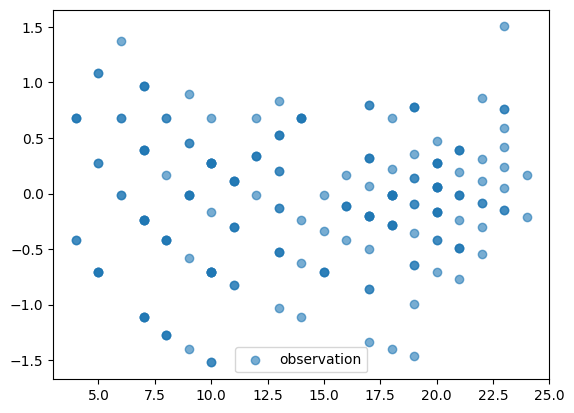

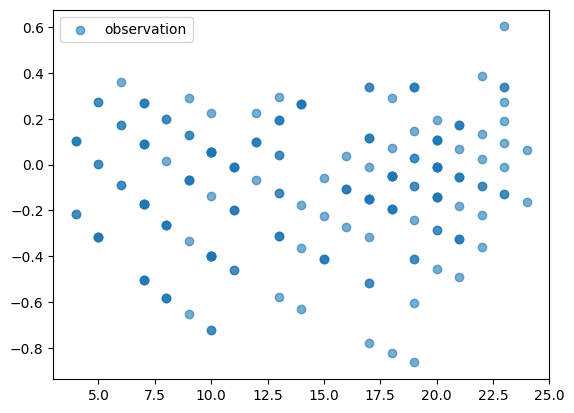

In [635]:
rep_i = 2
plt.scatter(negative_count_rep[rep_i], negative_raw_lfc_rep[rep_i], alpha=0.6, label="observation")
#plt.scatter(positive_count_rep, positive_raw_lfc_rep, alpha=0.6, label="positive")
#plt.scatter(negative_count_rep, negative_raw_lfc_rep, alpha=0.6, label="negative")
plt.legend()
plt.show()

plt.scatter(negative_count_rep[rep_i], negative_lfc_rep[rep_i], alpha=0.6, label="observation")
#plt.scatter(positive_count_rep, positive_raw_lfc_rep, alpha=0.6, label="positive")
#plt.scatter(negative_count_rep, negative_raw_lfc_rep, alpha=0.6, label="negative")
plt.legend()
plt.show()

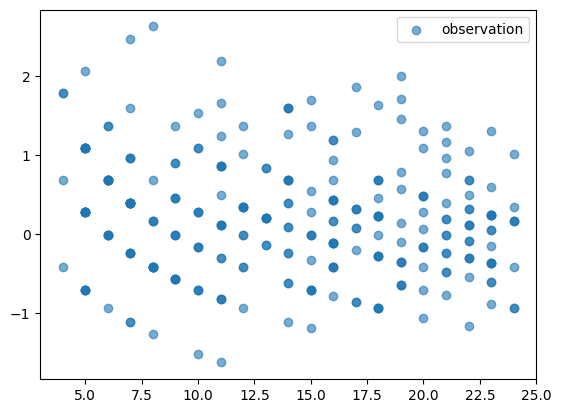

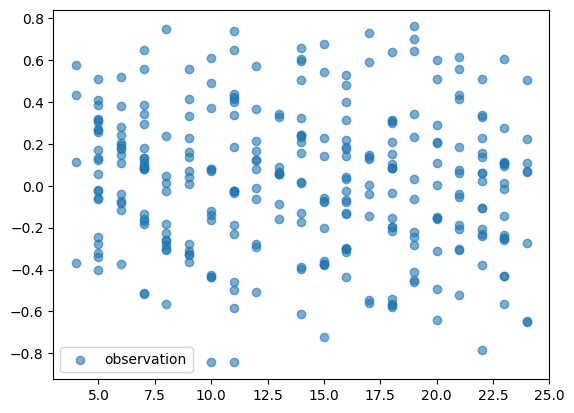

In [636]:
rep_i=2
plt.scatter(observational_count_rep[rep_i], observational_raw_lfc_rep[rep_i], alpha=0.6, label="observation")
#plt.scatter(positive_count_rep, positive_raw_lfc_rep, alpha=0.6, label="positive")
#plt.scatter(negative_count_rep, negative_raw_lfc_rep, alpha=0.6, label="negative")
plt.legend()
plt.show()

plt.scatter(observational_count_rep[rep_i], observational_lfc_rep[rep_i], alpha=0.6, label="observation")
#plt.scatter(positive_count_rep, positive_raw_lfc_rep, alpha=0.6, label="positive")
#plt.scatter(negative_count_rep, negative_raw_lfc_rep, alpha=0.6, label="negative")
plt.legend()
plt.show()

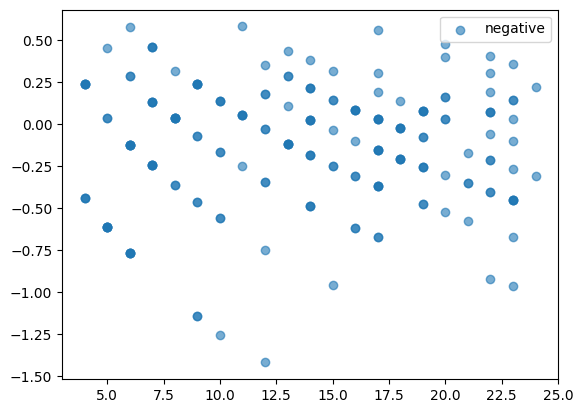

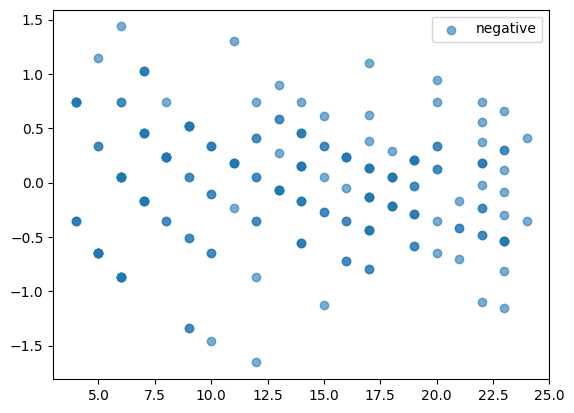

In [637]:
plt.scatter(negative_count_rep[0], negative_lfc_rep[0], alpha=0.6, label="negative")
plt.legend()
plt.show()

plt.scatter(negative_count_rep[0], negative_raw_lfc_rep[0], alpha=0.6, label="negative")
plt.legend()
plt.show()

In [638]:
negative_count_rep[rep_i]

[5.0,
 19.0,
 12.0,
 23.0,
 5.0,
 11.0,
 14.0,
 14.0,
 20.0,
 18.0,
 19.0,
 20.0,
 17.0,
 9.0,
 6.0,
 16.0,
 5.0,
 22.0,
 7.0,
 22.0,
 8.0,
 10.0,
 6.0,
 17.0,
 13.0,
 21.0,
 11.0,
 23.0,
 13.0,
 7.0,
 19.0,
 10.0,
 10.0,
 23.0,
 4.0,
 17.0,
 8.0,
 8.0,
 5.0,
 22.0,
 17.0,
 17.0,
 22.0,
 18.0,
 20.0,
 20.0,
 10.0,
 4.0,
 11.0,
 20.0,
 4.0,
 20.0,
 4.0,
 10.0,
 7.0,
 19.0,
 5.0,
 9.0,
 20.0,
 19.0,
 6.0,
 20.0,
 18.0,
 9.0,
 10.0,
 18.0,
 17.0,
 13.0,
 20.0,
 14.0,
 9.0,
 19.0,
 7.0,
 19.0,
 6.0,
 9.0,
 7.0,
 17.0,
 5.0,
 14.0,
 18.0,
 18.0,
 18.0,
 10.0,
 10.0,
 11.0,
 21.0,
 17.0,
 18.0,
 16.0,
 8.0,
 21.0,
 15.0,
 17.0,
 17.0,
 19.0,
 7.0,
 7.0,
 11.0,
 23.0,
 9.0,
 20.0,
 7.0,
 19.0,
 10.0,
 21.0,
 17.0,
 7.0,
 11.0,
 7.0,
 9.0,
 20.0,
 12.0,
 20.0,
 8.0,
 20.0,
 20.0,
 14.0,
 23.0,
 23.0,
 16.0,
 13.0,
 22.0,
 23.0,
 14.0,
 18.0,
 13.0,
 17.0,
 13.0,
 11.0,
 8.0,
 7.0,
 21.0,
 14.0,
 6.0,
 8.0,
 10.0,
 15.0,
 19.0,
 7.0,
 15.0,
 12.0,
 19.0,
 20.0,
 16.0,
 10.0,
 8.0,
 24.0,
 8.0,


In [639]:
negative_lfc_rep[rep_i]

[-0.3151052365112664,
 -0.6051461510333783,
 0.09813864683530682,
 -0.009588370740784672,
 0.2727994947162789,
 -0.009683858401545242,
 0.2649851481104059,
 -0.6306523205166469,
 0.1948980544925222,
 -0.05068107921923663,
 0.031021297521597258,
 0.10796267219028385,
 0.11413811029455911,
 -0.33222810120000174,
 -0.08769125084778172,
 0.03600461649583124,
 0.2727994947162789,
 -0.09148534528591004,
 0.2676505351735932,
 0.3851313994537548,
 -0.5819231404213351,
 0.2263909112324948,
 -0.08769125084778172,
 0.11413811029455911,
 0.0425580014276143,
 0.06960016328946321,
 -0.009683858401545242,
 0.27302710654862145,
 -0.12295637180101829,
 -0.5056649321514995,
 -0.09230493021438849,
 0.053079088814313176,
 -0.39892369616877793,
 0.09417640098451961,
 0.10297442911374162,
 -0.14969147366129515,
 -0.26137951782460783,
 -0.26137951782460783,
 -0.3151052365112664,
 -0.21811622877446285,
 -0.5160299386261309,
 -0.14969147366129515,
 0.026094988902022147,
 0.07064380059901434,
 -0.00895215659406

In [640]:
rep_i = 1
print(crispr_shrinkage.StatisticalHelperMethods.calculate_breusch_pagan(negative_count_rep[rep_i], negative_lfc_rep[rep_i]))
print(crispr_shrinkage.StatisticalHelperMethods.calculate_breusch_pagan(negative_count_rep[rep_i], negative_raw_lfc_rep[rep_i]))

3.8763610700374596
15.318691368431114


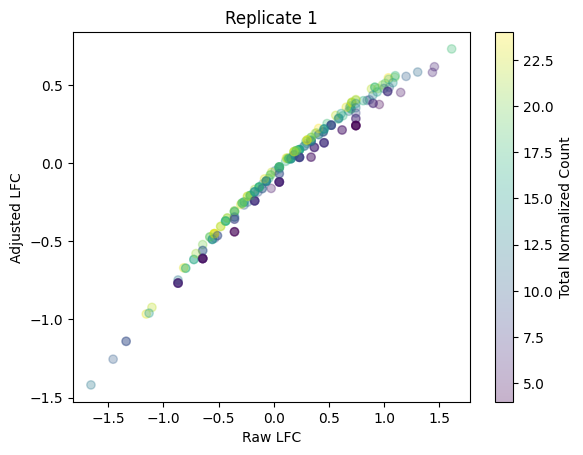

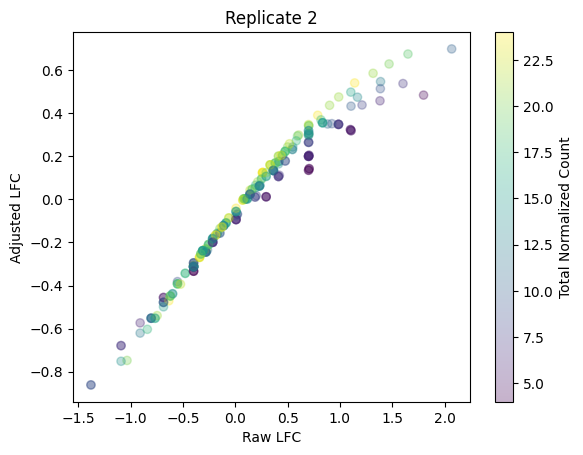

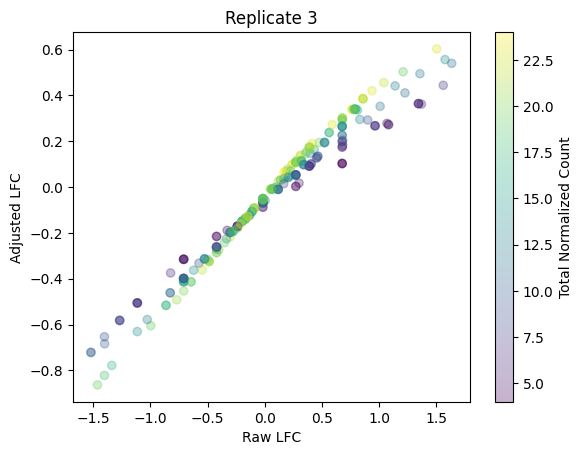

In [641]:
#plt.scatter(observational_raw_lfc_rep, observational_lfc_rep, c=observational_count_rep, marker=",", alpha=0.3)
for rep_i in range(3):
    plt.scatter(positive_raw_lfc_rep[rep_i], positive_lfc_rep[rep_i], c=positive_count_rep[rep_i], alpha=0.3, marker="o")
    plt.scatter(negative_raw_lfc_rep[rep_i], negative_lfc_rep[rep_i], c=negative_count_rep[rep_i], alpha=0.3, marker="o")
    plt.colorbar(label="Total Normalized Count")
    plt.xlabel("Raw LFC")
    plt.ylabel("Adjusted LFC")
    plt.title("Replicate {}".format(rep_i + 1))
    plt.show()

In [642]:
# LEFTOFF - Simulated a tiled region and troubleshoot. May need to adjust the loss function to prioritize differential guides.

In [643]:
# LEFTOFF: It seems that the shrinkage optimization is not working appropriately. I wonder if it is due to the position-less guide counts. Try and increase the position-containing positive control guides to see how the respond to shrinkage. Also compare the LFC before and after and validate where shrinkage is. Would also be nice to create another simulation example to test neighborhood. Also try and plot intermediate plots in the package (i.e. visualizing and logging optimization performance.)

In [644]:
positive_regions

[(50,
  5,
  array([0.        , 0.3040094 , 0.58134022, 0.80460065, 0.94967505,
         1.        , 0.94967505, 0.80460065, 0.58134022, 0.3040094 ,
         0.        ])),
 (100,
  3,
  array([0.        , 0.49357529, 0.86265631, 1.        , 0.86265631,
         0.49357529, 0.        ])),
 (150,
  10,
  array([0.        , 0.15362354, 0.3040094 , 0.44774487, 0.58134022,
         0.70136657, 0.80460065, 0.88816786, 0.94967505, 0.98732425,
         1.        , 0.98732425, 0.94967505, 0.88816786, 0.80460065,
         0.70136657, 0.58134022, 0.44774487, 0.3040094 , 0.15362354,
         0.        ])),
 (200,
  15,
  array([0.        , 0.10261159, 0.20427741, 0.3040094 , 0.40078728,
         0.49357529, 0.58134022, 0.66307025, 0.73779421, 0.80460065,
         0.86265631, 0.91122337, 0.94967505, 0.97750905, 0.99435851,
         1.        , 0.99435851, 0.97750905, 0.94967505, 0.91122337,
         0.86265631, 0.80460065, 0.73779421, 0.66307025, 0.58134022,
         0.49357529, 0.40078728, 0.3040

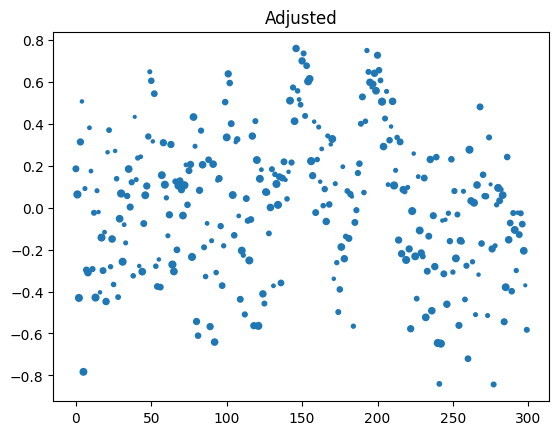

Text(0.5, 1.0, 'Raw')

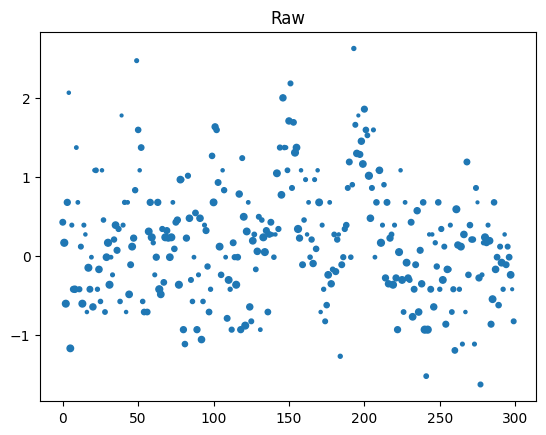

In [645]:
rep_i = 2
plt.scatter(observational_position, observational_lfc_rep[rep_i], s=observational_count_rep[rep_i])
plt.title("Adjusted")
plt.show()
plt.scatter(observational_position, observational_raw_lfc_rep[rep_i], s=observational_count_rep[rep_i])
plt.title("Raw")

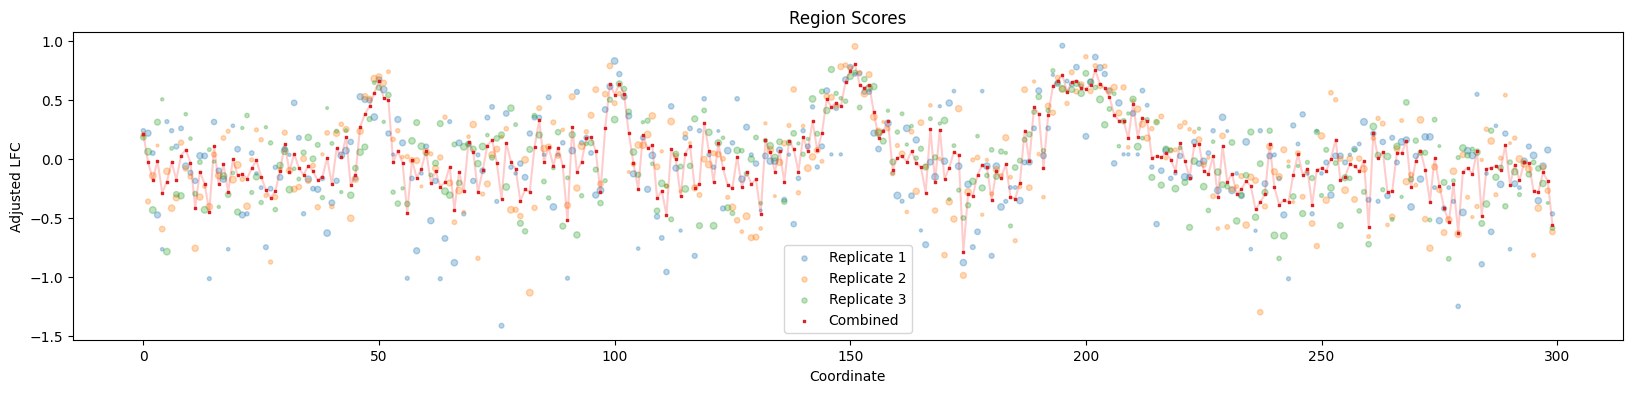

In [679]:
fig = plt.figure(figsize=(20, 4))

# Adds subplot on position 1
ax = fig.add_subplot(111)

ax.scatter(observational_position, observational_lfc_rep[0], s=observational_count_rep[0], alpha=0.3, label="Replicate 1")
ax.scatter(observational_position, observational_lfc_rep[1], s=observational_count_rep[1], alpha=0.3, label="Replicate 2")
ax.scatter(observational_position, observational_lfc_rep[2], s=observational_count_rep[2], alpha=0.3, label="Replicate 3")
ax.scatter(observational_position, observational_lfc, marker="s", s=2, label="Combined")
ax.plot(observational_position, observational_lfc,color="red", alpha=0.2)
ax.set_title("Region Scores")
ax.set_xlabel("Coordinate")
ax.set_ylabel("Adjusted LFC")
ax.legend()

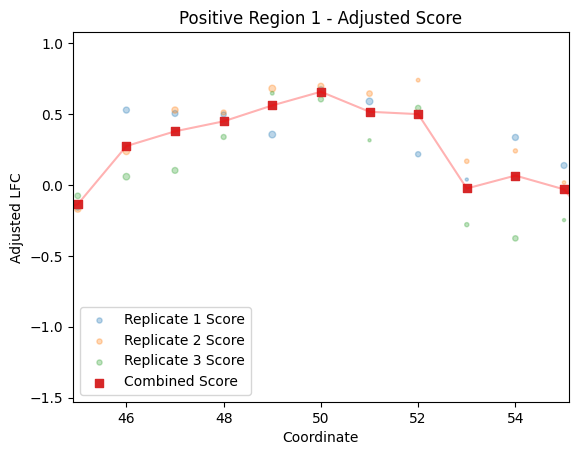

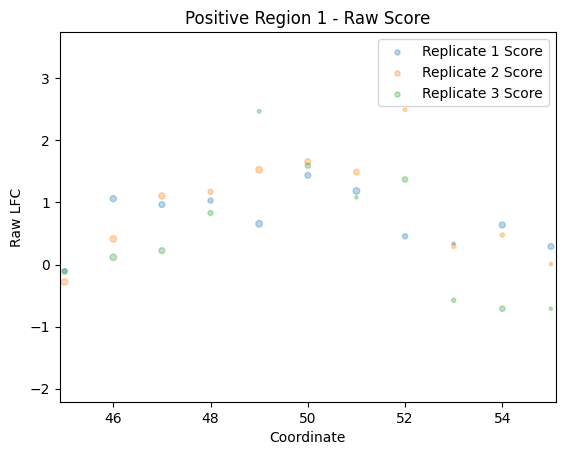

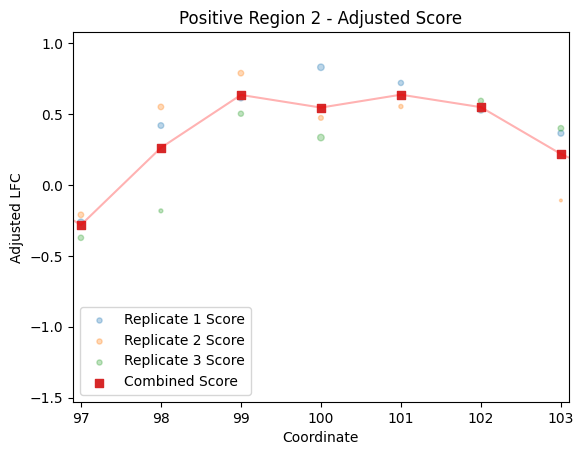

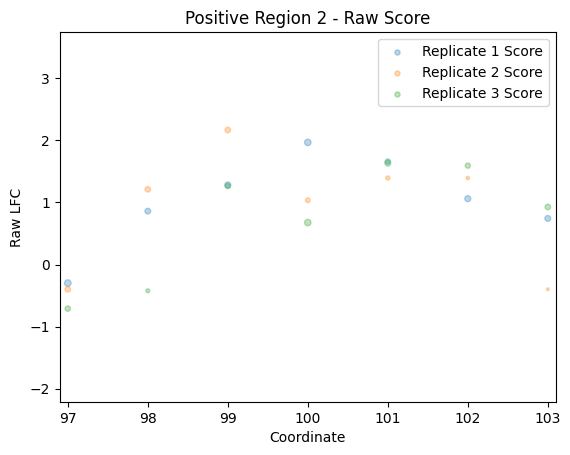

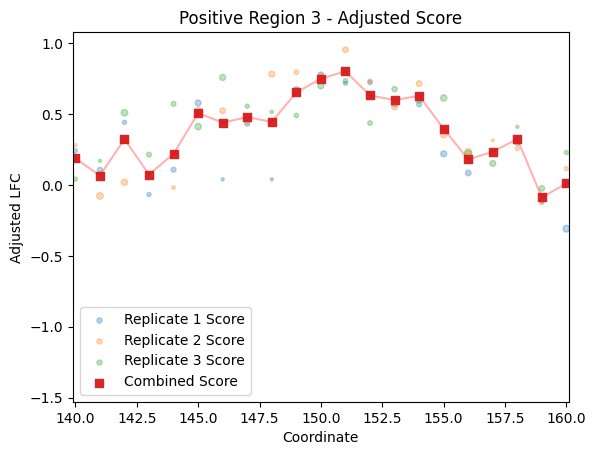

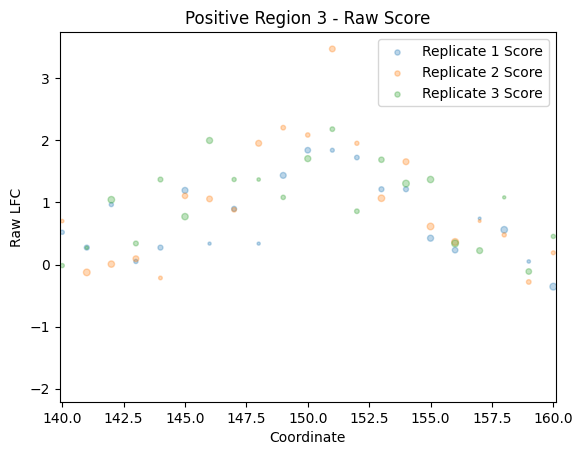

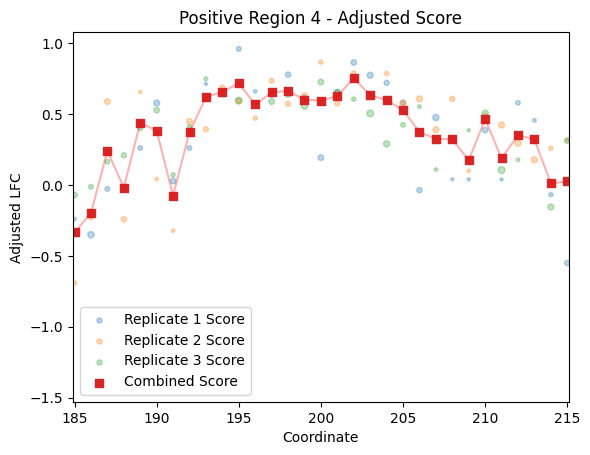

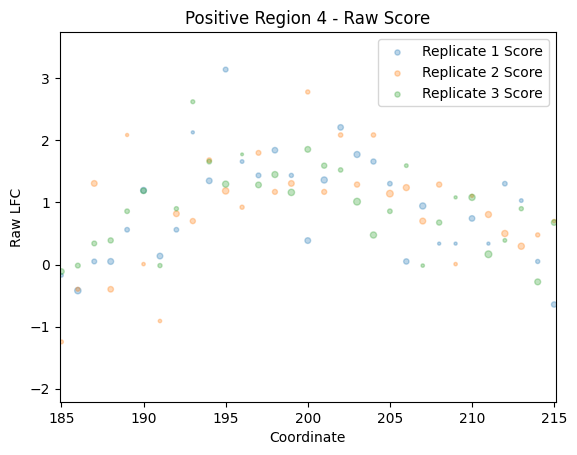

In [672]:
for reg_i, positive_region in enumerate(positive_regions):
    
    for rep_i in range(3):
        plt.scatter(observational_position, observational_lfc_rep[rep_i], s=observational_count_rep[rep_i], alpha=0.3, label="Replicate {} Score".format(rep_i + 1))

    plt.scatter(observational_position, observational_lfc, marker="s", label="Combined Score")
    plt.plot(observational_position, observational_lfc, color="red", alpha=0.3)
    plt.xlim(positive_region[0]-positive_region[1] - 0.1, positive_region[0]+positive_region[1] + 0.1)
    plt.title("Positive Region {} - Adjusted Score".format(reg_i+1))
    plt.xlabel("Coordinate")
    plt.ylabel("Adjusted LFC")
    plt.legend()
    plt.show()
    for rep_i in range(3):
        plt.scatter(observational_position, observational_raw_lfc_rep[rep_i], s=observational_count_rep[rep_i], alpha=0.3, label="Replicate {} Score".format(rep_i + 1))
    plt.xlim(positive_region[0]-positive_region[1] - 0.1, positive_region[0]+positive_region[1] + 0.1)
    plt.title("Positive Region {} - Raw Score".format(reg_i+1))
    plt.xlabel("Coordinate")
    plt.ylabel("Raw LFC")
    plt.legend()
    plt.show()